In [12]:
import sys
import time

In [13]:
import tensorflow as tf
import keras
from keras import layers
import keras_tuner as kt
import numpy as np
from PIL import Image

In [14]:
sys.modules['Image'] = Image

In [15]:
tf.get_logger().setLevel('ERROR')

In [16]:
import os

# folders = ("H", "S", "U", "FG", "OP", "P", "C")
folders = ("H", "S", "U", "F", "P", "C", "O", "0")

num_skipped = 0
for folder_name in folders:
    folder_path = os.path.join("Signs", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("PNG") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

In [17]:
image_size = (64, 40)
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    "Signs",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = keras.utils.image_dataset_from_directory(
    "Signs",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Deleted 0 images


In [18]:
class_names = train_ds.class_names
print(len(np.concatenate([i for x, i in train_ds], axis=0)))
print(class_names)

Found 129471 files belonging to 8 classes.
Using 103577 files for training.
Found 129471 files belonging to 8 classes.
Using 25894 files for validation.


In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(7):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

103577
['0', 'C', 'F', 'H', 'O', 'P', 'S', 'U']


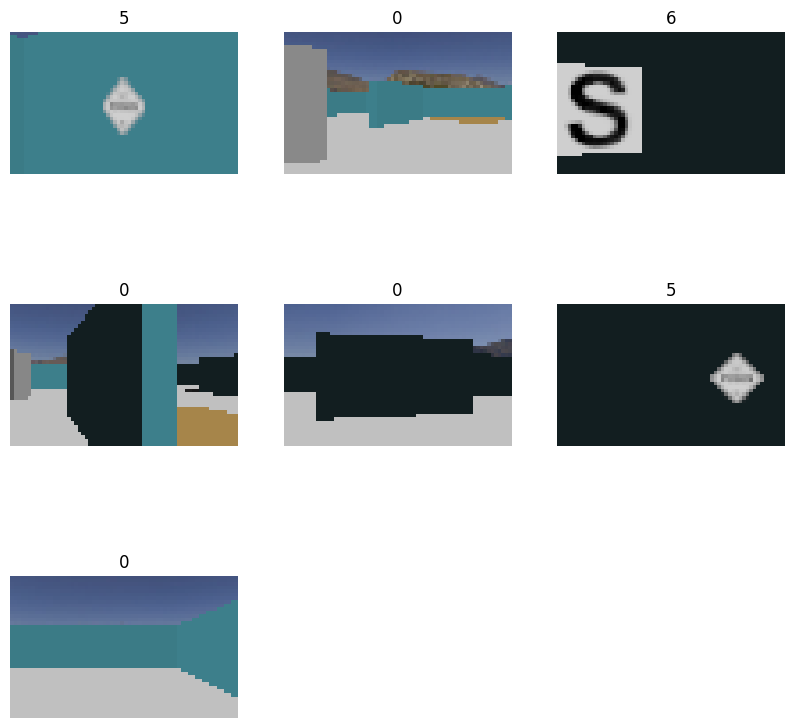

In [20]:
input_shape=image_size + (3,)
num_classes=len(folders)

In [21]:
def model_builder(hp):
    hp_last_units = hp.Int('units', min_value=32, max_value=768, step=32)
    hp_last_activation = hp.Choice("activation", ["relu", "tanh", "softmax"])
    hp_dropout_rate = hp.Choice("hp_dropout_rate", values=[.05, .1, .15, .2, .25, .3])

    model_layers = [
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(hp_dropout_rate),
        layers.Flatten(),
        layers.Dense(hp_last_units, activation=hp_last_activation),
        layers.Dense(num_classes, name="outputs")
    ]
    model_layers = list(filter(lambda item: item is not None, model_layers))
    model = keras.Sequential(model_layers)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

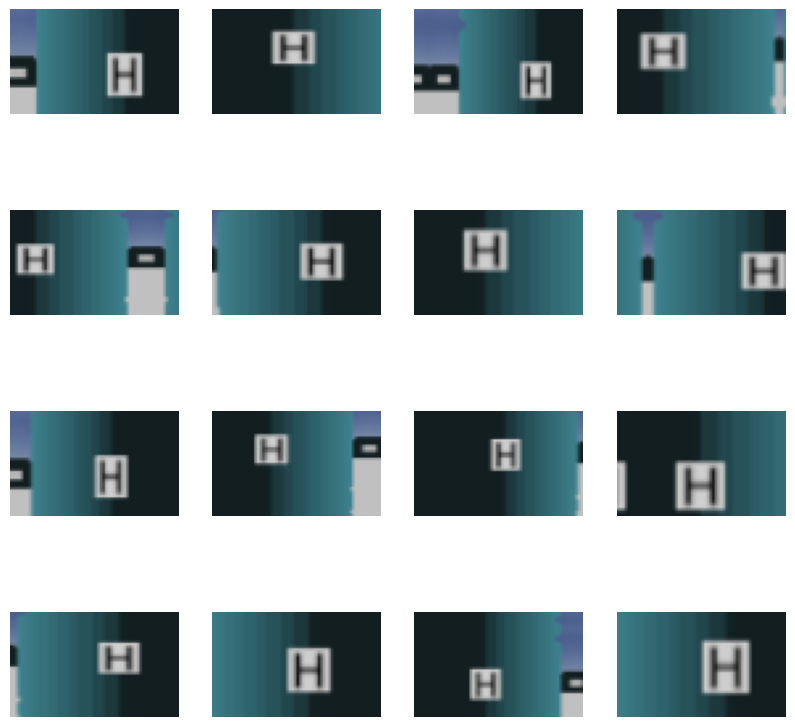

In [22]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='kt',
    project_name='erebus'
)

In [23]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

In [28]:
tuner.search(train_ds, validation_data=val_ds, epochs=75, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [29]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [30]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=75,
    validation_split=0.2
)

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(75)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
model.save('test_f-hp.keras')


units: 480
activation: relu
hp_dropout_rate: 0.25
learning_rate: 0.001



In [36]:
img = tf.keras.preprocessing.image.load_img(
    "Signs/S/55.png", target_size=image_size
)

Epoch 1/30
3237/3237 [==============================] - 64s 20ms/step - loss: 0.1898 - accuracy: 0.9359 - val_loss: 0.1209 - val_accuracy: 0.9635
Epoch 2/30
3237/3237 [==============================] - 58s 18ms/step - loss: 0.0647 - accuracy: 0.9810 - val_loss: 0.0396 - val_accuracy: 0.9881
Epoch 3/30
3237/3237 [==============================] - 59s 18ms/step - loss: 0.0538 - accuracy: 0.9842 - val_loss: 0.0467 - val_accuracy: 0.9892
Epoch 4/30
3237/3237 [==============================] - 67s 21ms/step - loss: 0.0481 - accuracy: 0.9858 - val_loss: 0.0214 - val_accuracy: 0.9935
Epoch 5/30
3237/3237 [==============================] - 62s 19ms/step - loss: 0.0455 - accuracy: 0.9867 - val_loss: 0.0201 - val_accuracy: 0.9936
Epoch 6/30
3237/3237 [==============================] - 60s 19ms/step - loss: 0.0424 - accuracy: 0.9876 - val_loss: 0.0218 - val_accuracy: 0.9937
Epoch 7/30
3237/3237 [==============================] - 60s 19ms/step - loss: 0.0402 - accuracy: 0.9884 - val_loss: 0.0220 -

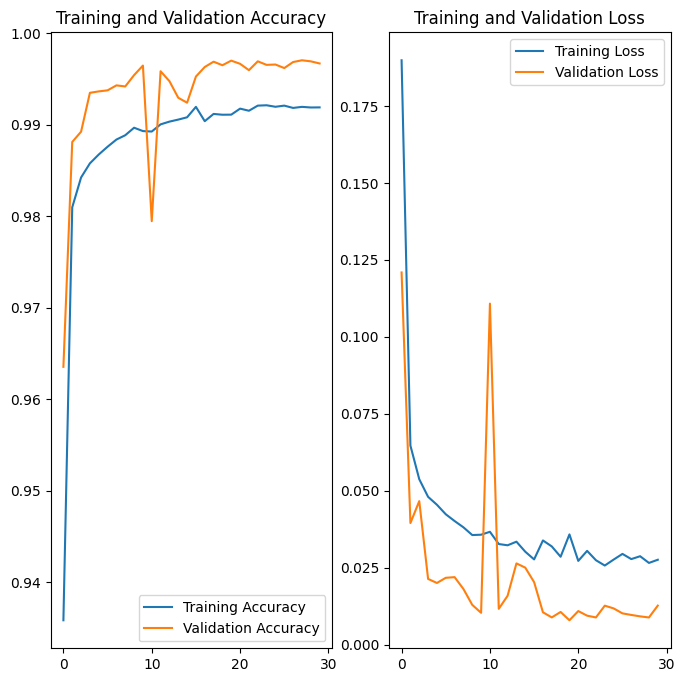

In [37]:
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

start = time.process_time() 
predictions = model.predict(img_array)
end = time.process_time()

print("Time: {}s".format(end-start))
print(list(map(lambda p, c: (c, p),predictions[0], class_names)))
print(predictions.argmax(axis=-1))
print(sorted(map(lambda p, c: (c, p),predictions[0], class_names), key=lambda t: t[1]))